In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import cv2
from torch.nn.functional import relu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/Users/yaoli/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using device: cpu


# 实验参考步骤
1. 从 https://monuseg.grand-challenge.org/Data/ 下载数据，训练数据下载地址：“Training Data”段落下“The dataset (images and annotations) can be downloaded using the following links- MoNuSeg 2018 Training data”，测试数据下载地址“Testing Data”段落下“Test set images with additional 7000 nuclear boundary annotations are available here MoNuSeg 2018 Testing data. ”；数据集介绍https://ieeexplore.ieee.org/document/8880654
2. 将数据集拷贝到本文件同一目录下

# 加载训练数据集

all_files ['TCGA-G9-6348-01Z-00-DX1', 'TCGA-MH-A561-01Z-00-DX1', 'TCGA-E2-A1B5-01Z-00-DX1', 'TCGA-CH-5767-01Z-00-DX1', 'TCGA-AR-A1AS-01Z-00-DX1', 'TCGA-G9-6336-01Z-00-DX1', 'TCGA-DK-A2I6-01A-01-TS1', 'TCGA-HE-7130-01Z-00-DX1', 'TCGA-A7-A13F-01Z-00-DX1', 'TCGA-G9-6356-01Z-00-DX1', 'TCGA-HE-7128-01Z-00-DX1', 'TCGA-FG-A87N-01Z-00-DX1', 'TCGA-G2-A2EK-01A-02-TSB', 'TCGA-NH-A8F7-01A-01-TS1', 'TCGA-AY-A8YK-01A-01-TS1', 'TCGA-38-6178-01Z-00-DX1', 'TCGA-A7-A13E-01Z-00-DX1', 'TCGA-HE-7129-01Z-00-DX1', 'TCGA-G9-6363-01Z-00-DX1', 'TCGA-21-5786-01Z-00-DX1', 'TCGA-18-5592-01Z-00-DX1', 'TCGA-B0-5698-01Z-00-DX1', 'TCGA-XS-A8TJ-01Z-00-DX1', 'TCGA-KB-A93J-01A-01-TS1', 'TCGA-UZ-A9PJ-01Z-00-DX1', 'TCGA-BC-A217-01Z-00-DX1', 'TCGA-G9-6362-01Z-00-DX1', 'TCGA-AR-A1AK-01Z-00-DX1', 'TCGA-RD-A8N9-01A-01-TS1', 'TCGA-B0-5711-01Z-00-DX1', 'TCGA-50-5931-01Z-00-DX1', 'TCGA-F9-A8NY-01Z-00-DX1', 'TCGA-E2-A14V-01Z-00-DX1', 'TCGA-21-5784-01Z-00-DX1', 'TCGA-49-4488-01Z-00-DX1', 'TCGA-B0-5710-01Z-00-DX1', 'TCGA-UZ-A9PN-01Z

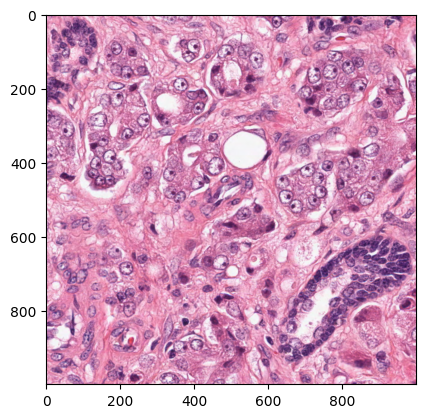

In [2]:
# 用这个方法可以找到所有的数据名称
folder_path = "./MoNuSeg 2018 Training Data/Tissue Images"
all_files = os.listdir(folder_path)
all_files = [filename[:-4] for filename in all_files]
print("all_files", all_files)

x_train = []
for file in all_files:
    img = plt.imread("./MoNuSeg 2018 Training Data/Tissue Images/"+file+".tif")
    x_train.append(img)

x_train = np.array(x_train, dtype=np.float32)/255. # 这个是之后要用的训练集细胞图像
print(x_train.shape)
plt.imshow(x_train[0,:,:,:])


In [3]:
# 一个用来把 xml 转化为图像的函数


def xml_to_mask(xml_path, image_shape):
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        for annotation in root.findall('Annotation'):
            for region in annotation.findall('Regions/Region'):
                vertices = []
                for vertex in region.findall('Vertices/Vertex'):
                    x = float(vertex.get('X'))
                    y = float(vertex.get('Y'))
                    vertices.append([x, y])
                
                if len(vertices) > 2:  # Need at least 3 points for a polygon
                    vertices = np.array(vertices, dtype=np.int32)
                    cv2.fillPoly(mask, [vertices], color=1)
                    
    except Exception as e:
        print(f"Error processing {xml_path}: {str(e)}")
    
    return mask

(37, 1000, 1000, 1)


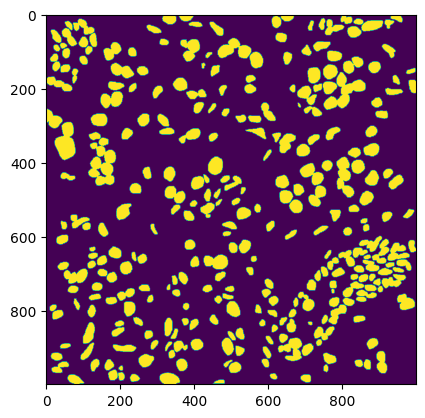

In [4]:
y_train = []
for file in all_files:
    mask = xml_to_mask("./MoNuSeg 2018 Training Data/Annotations/"+file+".xml", (x_train.shape[1],x_train.shape[2],1))
    y_train.append(mask)
y_train = np.array(y_train, dtype=np.float32) # 这个是之后要用的训练集细胞图分割结果
print(y_train.shape)
plt.imshow(y_train[0,:,:])

(333, 256, 256, 3) (333, 256, 256, 1)


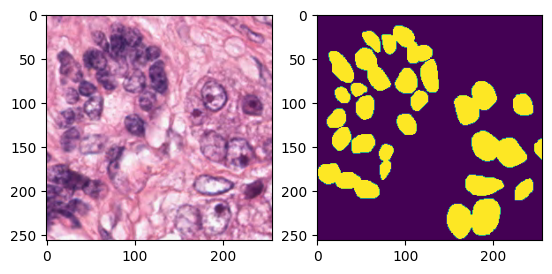

In [5]:
# 图像太大了，可以分成小块进行训练
x_train_patch = []
y_train_patch = []
for k in range(x_train.shape[0]):
    for i in range(3):
        for j in range(3):
            x_train_patch.append(x_train[k,i*256:(i+1)*256,j*256:(j+1)*256,:])
            y_train_patch.append(y_train[k,i*256:(i+1)*256,j*256:(j+1)*256,:])
x_train_patch = np.array(x_train_patch)
y_train_patch = np.array(y_train_patch)
print(x_train_patch.shape, y_train_patch.shape)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x_train_patch[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(y_train_patch[0,:,:,:])

In [6]:
# 得到训练集的 dataloader

# Data loaders
batch_size = 16

x_train_patch = np.transpose(x_train_patch, (0, 3, 1, 2))
y_train_patch = np.transpose(y_train_patch, (0, 3, 1, 2))
print(x_train_patch.shape, y_train_patch.shape)

train_dataset = TensorDataset(torch.tensor(x_train_patch), torch.tensor(y_train_patch))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

(333, 3, 256, 256) (333, 1, 256, 256)


# 练习：加载测试数据集
请仿照上面的步骤，创建测试集的dataloader

In [7]:
# Your code here
test_loader = None # 仿照上面创建这个（测试集文件夹不太一样，用上面的方法的话，需要对all_files根据扩展名进行一下过滤）

In [8]:


class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 256x256x3
        self.e11 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # output: 256x256x32
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output: 256x256x32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 128x128x32

        # input: 128x128x32
        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x64

        # input: 64x64x64
        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x128

        # input: 32x32x128
        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x256

        # input: 16x16x256
        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

model = UNet(1).to(device)

# 练习：完成模型训练部分的代码

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 10
train_losses, test_losses = [], []

# Your code here


torch.save(model, "./model.pt")

In [9]:
model = torch.load("./model.pt")

def iou(preds, targets):
    preds = preds>.5
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    
    iou = (intersection) / (union)
    
    return iou
    

preds = model(torch.tensor(x_train_patch).to(device))
targets = torch.tensor(y_train_patch).to(device)

ious = []
for i in range(preds.shape[0]):
    ious.append(iou(preds[i,:,:,:], targets[i,:,:,:]).detach().numpy())
ious = np.array(ious)

print(ious)
print(np.mean(ious))





[0.22007562 0.10944793 0.13699925 0.11625948 0.13081644 0.07480769
 0.05780264 0.15934461 0.33716053 0.6398416  0.65604955 0.62225235
 0.6006981  0.62691295 0.631291   0.5959952  0.59937876 0.58682716
 0.10890739 0.20084766 0.12686716 0.14542027 0.14854184 0.18260068
 0.15563771 0.05563826 0.15476955 0.09116447 0.11098666 0.15263444
 0.11303738 0.11133987 0.13972437 0.11998808 0.08585122 0.14547297
 0.66510355 0.40380713 0.50743574 0.6336436  0.5977025  0.6484631
 0.5597196  0.6737751  0.65061593 0.09607539 0.08837558 0.07839852
 0.09464143 0.09568301 0.12411589 0.079143   0.10438198 0.10781375
 0.7702513  0.78604954 0.77424085 0.75518113 0.80747736 0.71940506
 0.73251784 0.7980911  0.74134773 0.34943387 0.30209482 0.4127681
 0.25124052 0.31813386 0.44495198 0.25957477 0.37218755 0.37305957
 0.4800291  0.45616233 0.5514901  0.71624583 0.54616004 0.65351814
 0.52628744 0.55929315 0.5855111  0.19842929 0.25330076 0.3288599
 0.17720878 0.2517615  0.26125658 0.2469202  0.22283712 0.2056935

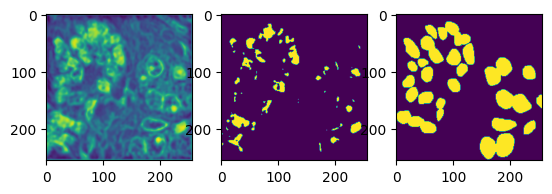

In [11]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(preds.detach().numpy()[0,0,:,:])
plt.subplot(1,3,2)
plt.imshow(preds.detach().numpy()[0,0,:,:]>0.5)
plt.subplot(1,3,3)
plt.imshow(targets.detach().numpy()[0,0,:,:])

In [ ]:
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 练习：完成模型测试部分

In [ ]:
# Your code here

# 练习要求
训练模型至少达到上面的效果。可通过增加训练轮数、改变模型结构(paper with code)、增加transform等方式

使用显卡训练 https://www.autodl.com/login